In [1]:
def set_plot_style():
    plt.rcParams['axes.edgecolor'] = 'silver'
    plt.rcParams['axes.titleweight'] = 'bold'
    plt.rcParams['axes.labelweight'] = 'bold'
    plt.rcParams['axes.labelweight'] = 'bold'
    plt.rcParams['xtick.labelsize'] = 18 
    plt.rcParams['ytick.labelsize'] = 18
    plt.rcParams['grid.alpha'] = .3 
    ax = plt.gca()
    ax.set_facecolor((247/255,249/255,247/255))
    ax.title.set_position([.5,1.02])
    ax.xaxis.labelpad = 10
    ax.yaxis.labelpad = 10
    ax.grid(False)

    

def plot_fitted_vs_actual(y_test, y_pred):
    
    plt.figure(figsize=(16,8))
    plt.scatter(y_test, y_pred, alpha=.56, color='#2951a0')
    plt.title('Actual Sale Price vs. Predicted Sale Price', fontsize=18)
    plt.ylabel('Predicted Sale Price', fontsize=14)
    _ = plt.xlabel('Actual Sale Price', fontsize=14)
    set_plot_style()
    
def plot_fitted_vs_resid(y_test, y_pred):
    
    residuals = [t - p for t, p in zip(y_test, y_pred)]
    
    plt.figure(figsize=(16,8))
    plt.scatter(y_pred, residuals, alpha=.56, color='#2951a0')
    plt.title('Residuals vs. Fitted Values', fontsize=18)
    plt.ylabel('Residuals', fontsize=14)
    _ = plt.xlabel('Fitted Values', fontsize=14)
    set_plot_style()
    
    
class gradient:
    def __init__(self, initial_color):
        self.color=initial_color
        self.current_color = initial_color/255
        
    def get_current_color(self):
        self.current_color = self.current_color*.95
        return(tuple(self.current_color))

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from numpy import *
import math
import networkx as nx
# from inferential_stats import *
from matplotlib.colors import LinearSegmentedColormap
import warnings
warnings.filterwarnings('ignore')
sns.set()

In [3]:
business_df = pd.read_csv('data/yelp_business.csv')

In [4]:
business_df.head()

,business_id,name,neighborhood,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,categories
0,FYWN1wneV18bWNgQjJ2GNg,"""Dental by Design""",NaN,"""4855 E Warner Rd, Ste B9""",Ahwatukee,AZ,85044,33.330690,-111.978599,4.0,22,1,Dentists;General Dentistry;Health & Medical;Or...
1,He-G7vWjzVUysIKrfNbPUQ,"""Stephen Szabo Salon""",NaN,"""3101 Washington Rd""",McMurray,PA,15317,40.291685,-80.104900,3.0,11,1,Hair Stylists;Hair Salons;Men's Hair Salons;Bl...
2,KQPW8lFf1y5BT2MxiSZ3QA,"""Western Motor Vehicle""",NaN,"""6025 N 27th Ave, Ste 1""",Phoenix,AZ,85017,33.524903,-112.115310,1.5,18,1,Departments of Motor Vehicles;Public Services ...
3,8DShNS-LuFqpEWIp0HxijA,"""Sports Authority""",NaN,"""5000 Arizona Mills Cr, Ste 435""",Tempe,AZ,85282,33.383147,-111.964725,3.0,9,0,Sporting Goods;Shopping
4,PfOCPjBrlQAnz__NXj9h_w,"""Brick House Tavern + Tap""",NaN,"""581 Howe Ave""",Cuyahoga Falls,OH,44221,41.119535,-81.475690,3.5,116,1,American (New);Nightlife;Bars;Sandwiches;Ameri...


In [5]:
def load_and_reduce_data(file_path, chunksize, reduction_factor):
    framelist = []
    for chunk in  pd.read_csv(file_path, chunksize=chunksize):
        rangelist = list(range(0, chunk.shape[0]))
        selection = list(np.random.choice(rangelist, round(chunk.shape[0]/reduction_factor), replace=False))
        df = chunk.iloc[selection]
        framelist.append(df)

    return(pd.concat(framelist))

In [6]:
def filter_data_by_ids(filepath, chunksize, att_name, ids):
    framelist=[]
    for chunk in pd.read_csv(filepath, chunksize=chunksize):
        chunk = chunk[chunk[att_name].isin(ids)]
        framelist.append(chunk)
        
    return(pd.concat(framelist))

In [7]:
def load_data(file_path, chunksize):
    framelist=[]
    for chunk in  pd.read_csv(file_path, chunksize=chunksize):
        framelist.append(chunk)
    return(pd.concat(framelist))

In [8]:
business_df = load_data('data/yelp_business.csv', 500)

In [9]:
business_attributes_df = load_data('data/yelp_business_attributes.csv', 500)
user_df = load_and_reduce_data('data/yelp_user.csv', 2000, 10)

In [10]:
review_df = filter_data_by_ids('data/yelp_review.csv', 1000, 'user_id', user_df['user_id'].values)

In [11]:
random_business = business_df.iloc[4]

In [12]:
random_business.review_count

116

In [13]:
 r = np.random.RandomState(seed=5)
r.random_integers(1, 10, size=(3,2))

array([[ 4,  7],
       [ 7,  1],
       [10,  9]])

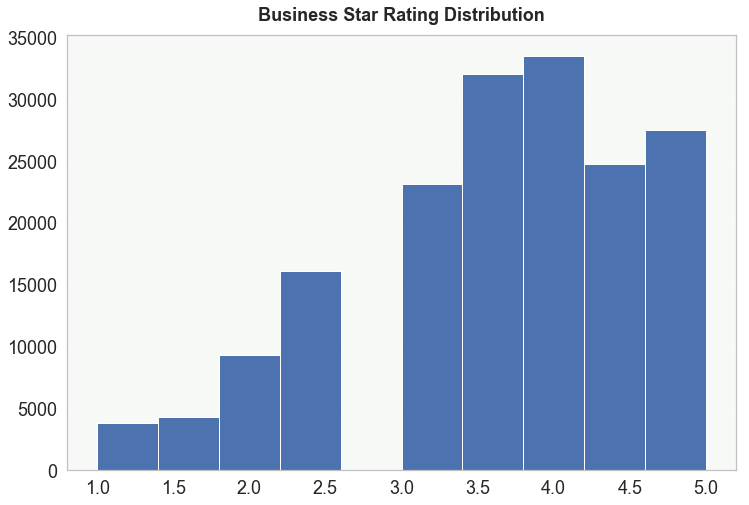

In [14]:
plt.figure(figsize=(12, 8))
set_plot_style()
plt.title('Business Star Rating Distribution', fontsize=18)
_ = business_df['stars'].hist()

Note the huge gap in reviews, almost no reviews in the 2.5 to 3.0 range. Lets confirm this with a pandas filter:

In [15]:
rating_gap = business_df[(business_df['stars'] < 3.0) & (business_df['stars'] > 2.6)]
rating_gap.head()

,business_id,name,neighborhood,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,categories


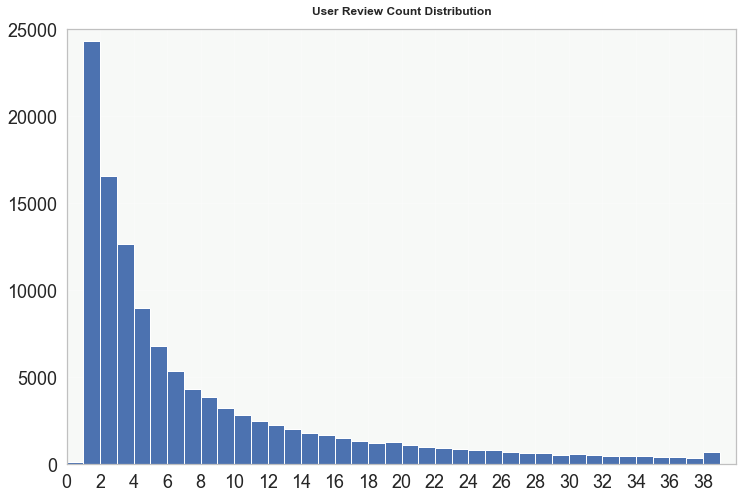

In [16]:
plt.figure(figsize=(12, 8))
set_plot_style()
plt.ylim(0, 25000)
plt.xlim(0, 40)
plt.xticks(range(0,40,2))
plt.title('User Review Count Distribution')
_ = user_df['review_count'].hist(bins=list(range(0,40)))

In [17]:
business_attributes_df = load_data('data/yelp_business_attributes.csv', 500)

In [18]:
business_attributes_df.head(12)

,business_id,AcceptsInsurance,ByAppointmentOnly,BusinessAcceptsCreditCards,BusinessParking_garage,BusinessParking_street,BusinessParking_validated,BusinessParking_lot,BusinessParking_valet,HairSpecializesIn_coloring,...,Corkage,DietaryRestrictions_dairy-free,DietaryRestrictions_gluten-free,DietaryRestrictions_vegan,DietaryRestrictions_kosher,DietaryRestrictions_halal,DietaryRestrictions_soy-free,DietaryRestrictions_vegetarian,AgesAllowed,RestaurantsCounterService
0,FYWN1wneV18bWNgQjJ2GNg,Na,Na,Na,True,Na,Na,Na,Na,Na,...,Na,Na,Na,Na,Na,Na,Na,Na,Na,Na
1,He-G7vWjzVUysIKrfNbPUQ,Na,Na,Na,Na,Na,Na,Na,Na,Na,...,Na,Na,Na,Na,Na,Na,Na,Na,Na,Na
2,8DShNS-LuFqpEWIp0HxijA,Na,Na,Na,Na,Na,Na,Na,Na,Na,...,Na,Na,Na,Na,Na,Na,Na,Na,Na,Na
3,PfOCPjBrlQAnz__NXj9h_w,Na,Na,Na,Na,Na,Na,Na,Na,Na,...,Na,Na,Na,Na,Na,Na,Na,Na,Na,Na
4,o9eMRCWt5PkpLDE0gOPtcQ,Na,Na,Na,Na,False,False,False,False,False,...,Na,Na,Na,Na,Na,Na,Na,Na,Na,Na
5,kCoE3jvEtg6UVz5SOD3GVw,Na,Na,False,Na,Na,Na,Na,Na,Na,...,Na,Na,Na,Na,Na,Na,Na,Na,Na,Na
6,OD2hnuuTJI9uotcKycxg1A,Na,Na,Na,Na,Na,Na,Na,Na,Na,...,Na,Na,Na,Na,Na,Na,Na,Na,Na,Na
7,EsMcGiZaQuG1OOvL9iUFug,Na,Na,Na,Na,Na,Na,Na,Na,Na,...,Na,Na,Na,Na,Na,Na,Na,Na,Na,Na
8,TGWhGNusxyMaA4kQVBNeew,Na,Na,Na,True,Na,Na,Na,Na,Na,...,Na,Na,Na,Na,Na,Na,Na,Na,Na,Na
9,XOSRcvtaKc_Q5H1SAzN20A,Na,Na,Na,Na,False,False,False,True,False,...,Na,Na,Na,Na,Na,Na,Na,Na,Na,Na


In [19]:
restaurants_df = business_df[business_df['categories'].str.contains('Restaurant')]

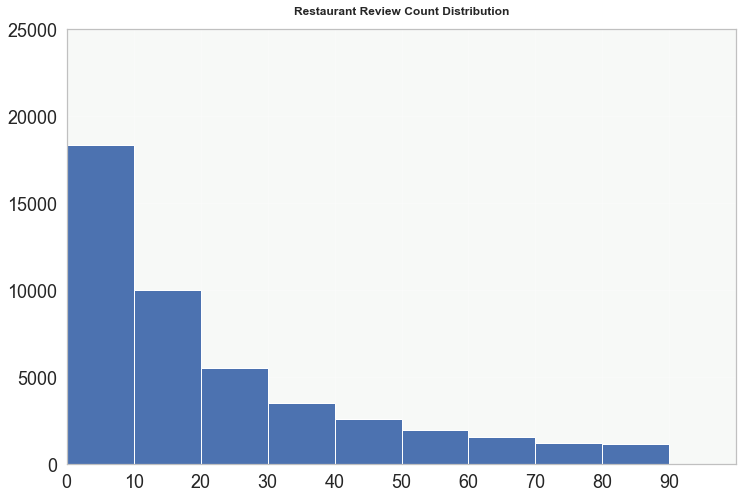

In [20]:
plt.figure(figsize=(12, 8))
set_plot_style()
plt.ylim(0, 25000)
plt.xlim(0, 100)
plt.xticks(range(0,100,10))
plt.title('Restaurant Review Count Distribution')
_ = restaurants_df['review_count'].hist(bins=list(range(0,100,10)))

In [21]:
user_df.head()

,user_id,name,review_count,yelping_since,friends,useful,funny,cool,fans,elite,...,compliment_more,compliment_profile,compliment_cute,compliment_list,compliment_note,compliment_plain,compliment_cool,compliment_funny,compliment_writer,compliment_photos
1534,R2Y161LYTv74iJRQ4tH9Yw,Rob,13,2011-09-01,"p3P2XVzO8aSPGL0xGEHBCA, 8gO5GPyZZgtpouv1pmPprA...",0,0,0,1,None,...,1,0,0,0,0,0,1,1,0,0
1215,919VXfbGCsWAqZtb2W9cmA,Robert,2,2009-06-06,"Mftr8ylqXCWxPINP4h-Cxg, ybgvv-cNl-DKhIUNjsQCfA...",2,0,0,0,None,...,0,0,0,0,0,0,0,0,0,0
1174,g-E-7BgTl9fA5wkRf4q17g,Jeffrey,2,2010-11-18,"rdmhE3c6Tx1nUAz7lwAZcQ, QRNrZdF0D0dgAgONpTRn9g...",0,0,2,0,None,...,0,0,0,0,1,0,0,0,0,0
1500,ZAhWnYPng4CVsqa8ktslLQ,Lorna,67,2009-09-22,"9urF3iDii6n-hrDM4WXDtA, K5t1yjOc5HPi_rwkCptemA...",82,12,2,4,None,...,0,0,0,0,0,3,1,1,0,0
963,pspoAHgIcQu49Q8zS_aB2Q,Meli,4,2016-04-23,"RUjh73zaqjyXrH5gm-PlOQ, Hj-yc5OFxX9Uoi8qQCKVrQ...",4,1,0,0,None,...,0,0,0,0,0,0,0,0,0,0


In [22]:
best_users = user_df.sort_values(['review_count'], ascending=False).iloc[0:20]

In [23]:
best_user_reviews = review_df[review_df['user_id'].isin(best_users['user_id'].values)]

In [24]:
best_user_reviews.head()

,review_id,user_id,business_id,stars,date,text,useful,funny,cool
169118,pNocrNRDjQMarlj1MBLaxw,NOUfyJW-BAo_-Cbfo8edww,I8pcOpgsZOPdkg2sV73hiw,5,2008-08-08,My aunt took me to Mount Pleasant Cemetery on ...,4,3,7
169119,OZAcCSzrpE1ISwjbtbcg4Q,NOUfyJW-BAo_-Cbfo8edww,8KkyDoWrqOeZb--qUtNwjQ,4,2008-08-12,"Posh and exclusive, HR is Canada's premiere de...",7,3,7
273199,kCmiDNweNQKrymDCKVrJcQ,Ve0LUwcrzxL7w0RYgY4Aaw,KOQw4e1rwCY5e0RnmB5rgQ,3,2012-10-14,This place is such a dive that it's awesome. I...,7,2,5
273200,wri7ReZp9URnuishwbv9kw,Ve0LUwcrzxL7w0RYgY4Aaw,91EhRceds781OLo3M4BDrA,5,2012-10-11,"What the?! I had to travel to Phoenix, AZ to s...",13,13,13
273201,BqcKTf4uEv_iD6Uit-e9hA,Ve0LUwcrzxL7w0RYgY4Aaw,S4mPzOP0GzaeBiNE1jNLpQ,3,2009-05-22,It's hard to decide whether to give this hotel...,5,1,1


In [25]:
best_user_reviews = pd.merge(best_user_reviews, best_users[['name','user_id']], on='user_id')
best_user_reviews.columns

Index(['review_id', 'user_id', 'business_id', 'stars', 'date', 'text',
       'useful', 'funny', 'cool', 'name'],
      dtype='object')

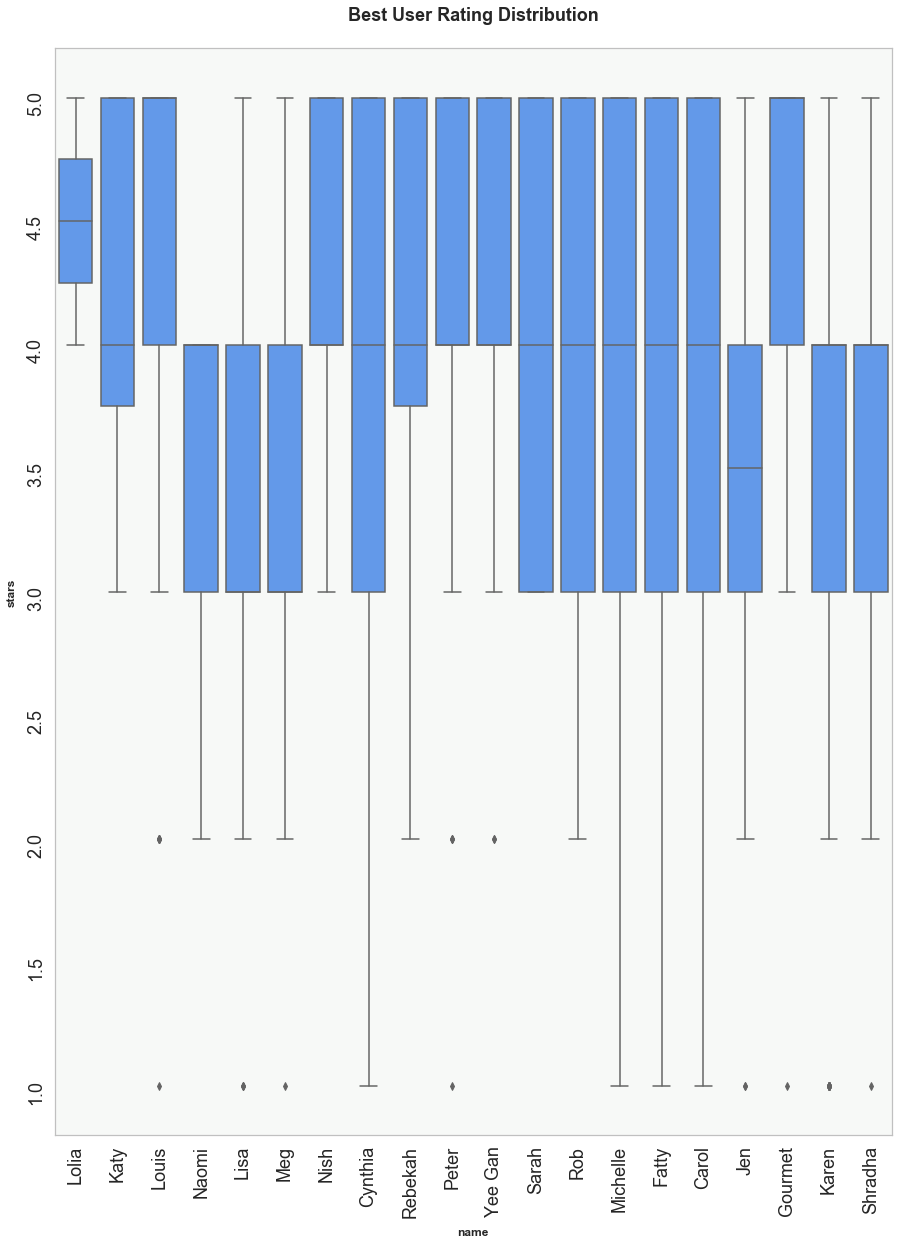

In [26]:
plt.figure(figsize=(15,20))
set_plot_style()
plt.yticks(rotation=90)
plt.xticks(rotation=90)
plt.title("Best User Rating Distribution", fontsize=18)
_ = sns.boxplot(x='name', y='stars', data=best_user_reviews, color='#4d94ff')

In [27]:
best_user_reviews['char_count'] = best_user_reviews['text'].str.len()

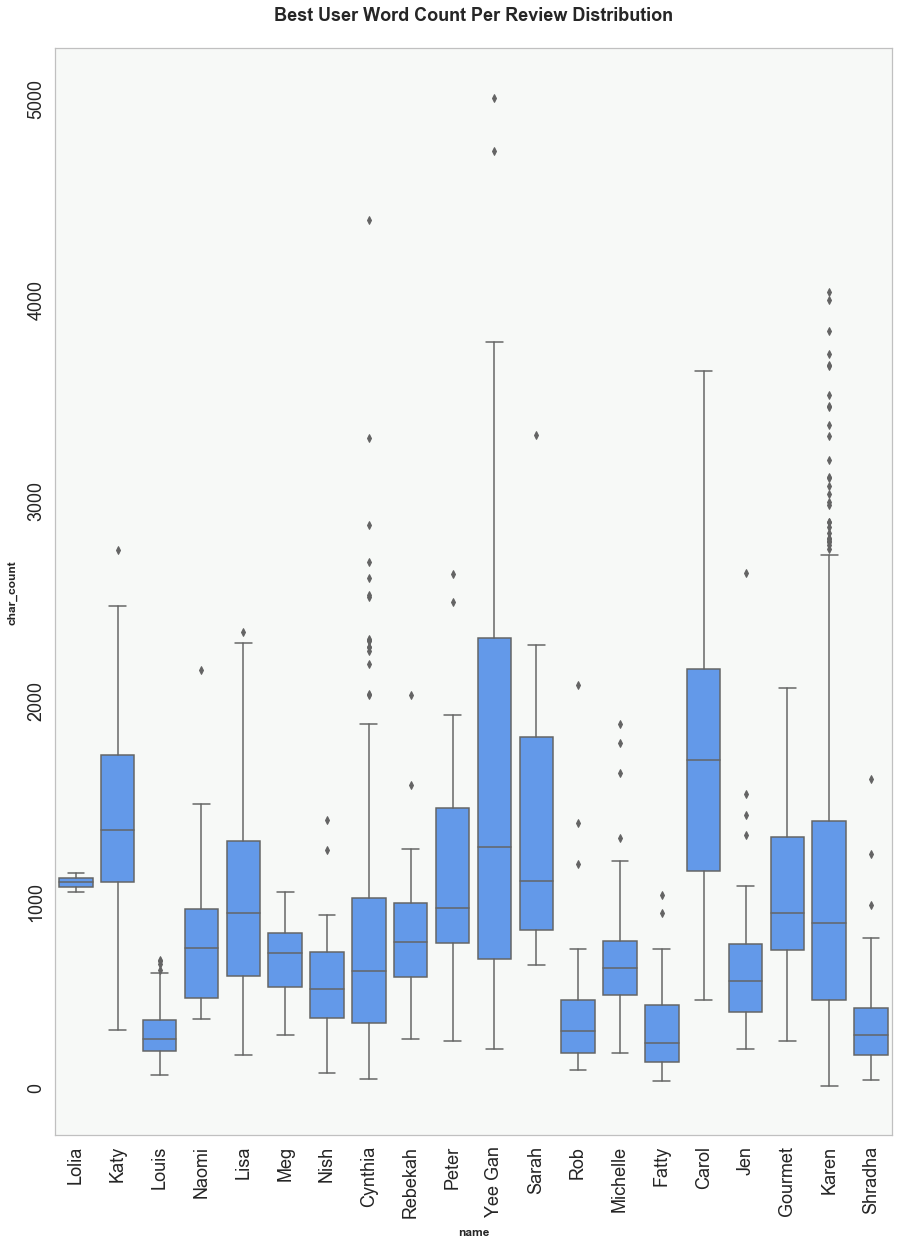

In [28]:
plt.figure(figsize=(15,20))
set_plot_style()
plt.yticks(rotation=90)
plt.xticks(rotation=90)
plt.title("Best User Word Count Per Review Distribution", fontsize=18)
_ = sns.boxplot(x='name', y='char_count', data=best_user_reviews, color='#4d94ff')

In [29]:
restaurants_df.head()

,business_id,name,neighborhood,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,categories
4,PfOCPjBrlQAnz__NXj9h_w,"""Brick House Tavern + Tap""",NaN,"""581 Howe Ave""",Cuyahoga Falls,OH,44221,41.119535,-81.475690,3.5,116,1,American (New);Nightlife;Bars;Sandwiches;Ameri...
5,o9eMRCWt5PkpLDE0gOPtcQ,"""Messina""",NaN,"""Richterstr. 11""",Stuttgart,BW,70567,48.727200,9.147950,4.0,5,1,Italian;Restaurants
10,XOSRcvtaKc_Q5H1SAzN20A,"""East Coast Coffee""",NaN,"""737 West Pike St""",Houston,PA,15342,40.241548,-80.212815,4.5,3,0,Breakfast & Brunch;Gluten-Free;Coffee & Tea;Fo...
14,fNMVV_ZX7CJSDWQGdOM8Nw,"""Showmars Government Center""",Uptown,"""600 E 4th St""",Charlotte,NC,28202,35.221647,-80.839345,3.5,7,1,Restaurants;American (Traditional)
15,l09JfMeQ6ynYs5MCJtrcmQ,"""Alize Catering""",Yonge and Eglinton,"""2459 Yonge St""",Toronto,ON,M4P 2H6,43.711399,-79.399339,3.0,12,0,Italian;French;Restaurants


In [30]:
restaurants_df[restaurants_df['state'].str.contains('CA')]

,business_id,name,neighborhood,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,categories
22535,UntbR8C0Mxsfd-hNBZXO-w,"""La Chamade""",NaN,"""Via San Nullo 48""",Montreal,CA,80078,40.891417,14.092636,4.5,4,1,Pizza;Restaurants


In [31]:
restaurant_count_by_city = restaurants_df.groupby('city')['city'].count().sort_values(ascending=False).to_frame()
restaurant_count_by_city.columns = ['count']
restaurant_count_by_city = restaurant_count_by_city.reset_index()

In [32]:
restaurant_count_by_city[(restaurant_count_by_city['count'] >100) & (restaurant_count_by_city['count'] <120)]

,city,count
49,Urbana,117
50,Monroeville,115
51,Middleton,114
52,Strongsville,113
53,Ludwigsburg,112
54,Kent,111
55,Brossard,107
56,North Olmsted,105


In [33]:
top_10_cities = restaurant_count_by_city.sort_values('count', ascending=False).iloc[0:10, :]

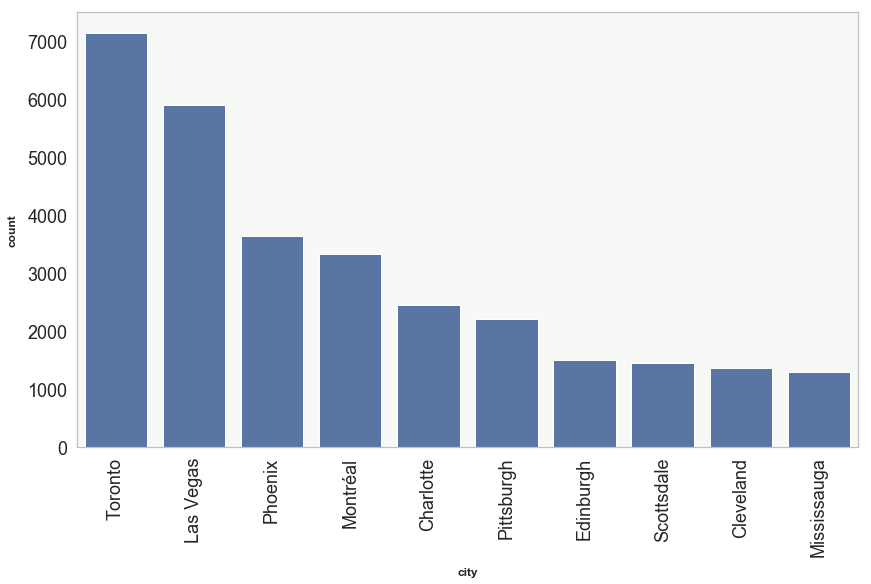

In [34]:
#Plot the top 10 cities with most restaurants

plt.figure(figsize=(14,8))
set_plot_style()
plt.xticks(rotation=90)
_ = sns.barplot(x='city', y='count', data=top_10_cities,
            label="Total", color="b")

In [35]:
business_attributes_df = pd.merge(business_attributes_df, restaurants_df[['name','business_id']], on='business_id')

In [36]:
selected_restaurants = restaurants_df[restaurants_df['city'] == 'Kent']

In [37]:
selected_restaurant_attributes_df = business_attributes_df[business_attributes_df['business_id'].isin(selected_restaurants['business_id'].values)]

In [38]:
selected_reviews = review_df[review_df['business_id'].isin(selected_restaurants['business_id'].values)]
selected_reviews = pd.merge(selected_reviews, user_df[['name','user_id']], on='user_id')
selected_reviews = pd.merge(selected_reviews, selected_restaurants[['name', 'business_id']], on='business_id', suffixes=('_user', '_business'))

In [39]:
selected_reviews.head()

,review_id,user_id,business_id,stars,date,text,useful,funny,cool,name_user,name_business
0,-nwxlMLW5mAIKEI7LmsuwQ,LqTlFmf8ewSuQCI0OGXslw,GdZ-Ryn9QzqV4glodYF6Jg,5,2012-04-15,Love Ray's Place. I have been going to this pl...,0,0,0,David,"""Rays Place"""
1,TBeBTWHLaNMLxw5-uDyiNA,C-CXUWZGwfvLEgih5nNdIA,GdZ-Ryn9QzqV4glodYF6Jg,5,2015-10-30,Best beer selection in Kent by far! And it's a...,0,0,0,Jason,"""Rays Place"""
2,mCcprNRJPB9x7oXyNH2wAw,v4fdrRDUzff8qDMSAysinQ,GdZ-Ryn9QzqV4glodYF6Jg,3,2014-11-02,The food was tasty. The service was not so goo...,2,0,0,Rachael,"""Rays Place"""
3,I_eTof4309NG2gwtS9KKVQ,DsqIqc8hQcfDci9ZlVZkJw,GdZ-Ryn9QzqV4glodYF6Jg,2,2016-03-20,There is a group of us from work that have bee...,1,0,0,Jonathan,"""Rays Place"""
4,0zhHi36wyrf1GPssJuq8Eg,GKqEvnzEm7XhjclF5LFy3Q,GdZ-Ryn9QzqV4glodYF6Jg,5,2015-07-11,Great place and will always come back but our ...,1,0,0,Jeff,"""Rays Place"""


In [40]:
user_ids_from_selected_restaurant_reviews = selected_reviews['user_id'].unique()
selected_restaurant_ids = selected_restaurants['business_id'].unique()

In [41]:
def restaurant_similarity(r1, r2):
    count = 0
    total = 0
    for val1, val2 in zip(r1.values, r2.values):
        if val1 != 'Na' and val2 != 'Na':
            total += 1
            if val1 == val2:
                count += 1
                
    return(count/82)

In [42]:
results_df = {'name':[]}

for index, current_row in selected_restaurant_attributes_df.iterrows():
    results_df['name'].append(current_row['name'])
    results_df[current_row['name']] = []
    for index, row_for_comparison in selected_restaurant_attributes_df.iterrows():
        results_df[current_row['name']].append(restaurant_similarity(current_row, row_for_comparison))


In [43]:
results_df = pd.DataFrame(results_df).set_index('name')

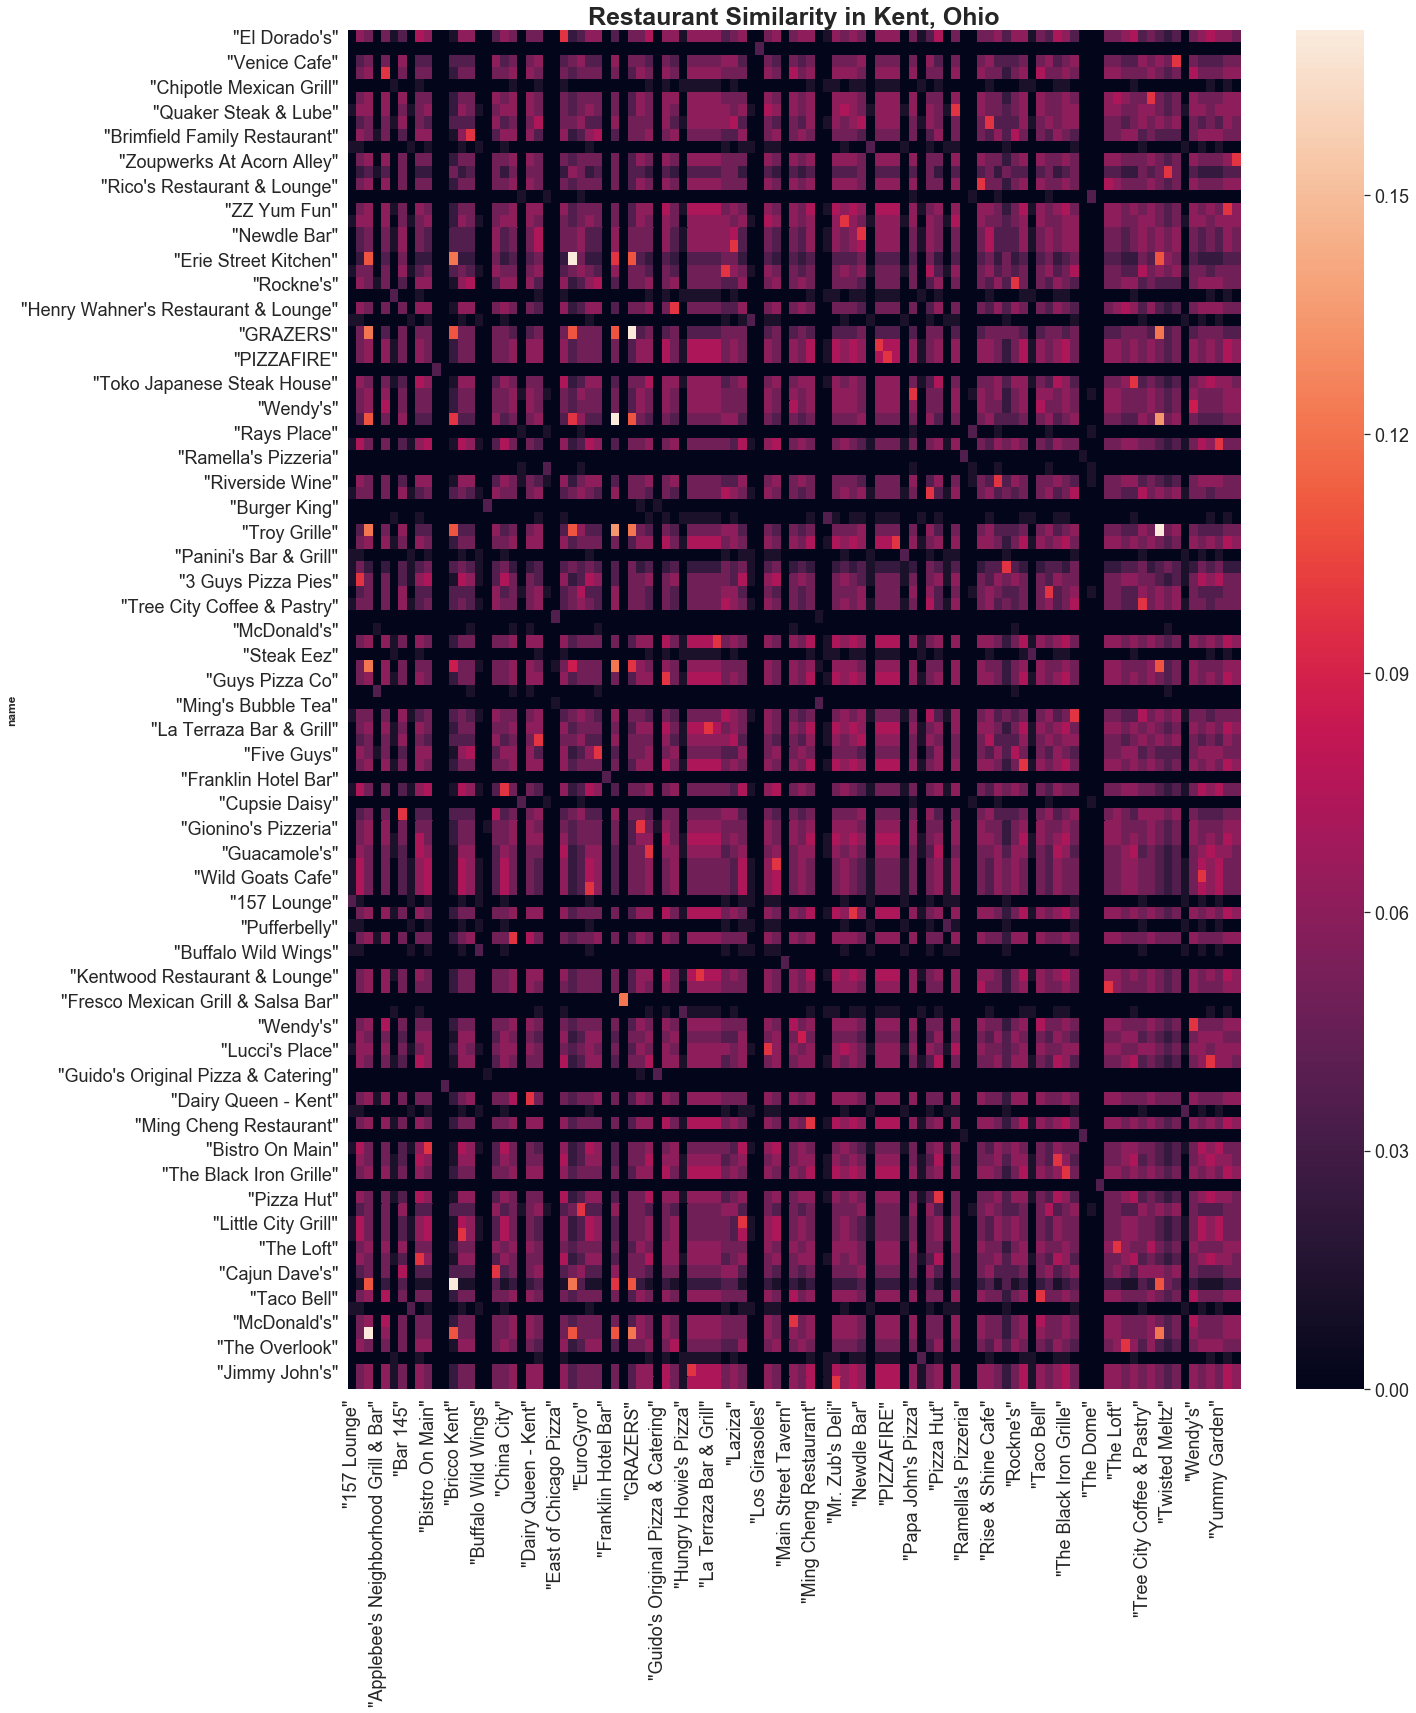

In [44]:
plt.figure(figsize=(20, 25))
plt.title("Restaurant Similarity in Kent, Ohio", fontsize=25)
sns.heatmap(results_df)

In [53]:
# Define get_nodes_from_partition()
def get_nodes_by_attribute(G, attribute_name, attribute):
    # Initialize an empty list for nodes to be returned
    nodes = []
    # Iterate over each node in the graph G
    for n in G.nodes():
        # Check that the node belongs to the particular partition
        if G.node[n][attribute_name] == attribute:
            # If so, append it to the list of nodes
            nodes.append(n)
    return nodes

#This function will evaluate how many common ratings two given users have
def shared_partition_nodes(G, node1, node2):
    
    def is_positive(rating):
        return rating>=3
    
    shared_nodes = []
    # Check that the nodes belong to the same partition
    assert G.node[node1]['partition'] == G.node[node2]['partition']

    # Get neighbors of node 1: nbrs1
    nbrs1 = G.neighbors(node1)
    # Get neighbors of node 2: nbrs2
    nbrs2 = G.neighbors(node2)

    # Compute the overlap using set intersections
    overlap = set(nbrs1).intersection(nbrs2)

    for node in overlap:
        if is_positive(G[node1][node]['weight']) == is_positive(G[node2][node]['weight']):
            shared_nodes.append(node)

    return shared_nodes

def user_similarity(G, user1, user2, proj_nodes):
    # Check that the nodes belong to the 'users' partition
    assert G.node[user1]['partition'] == 'users'
    assert G.node[user2]['partition'] == 'users'

    # Get the set of nodes shared between the two users
    shared_nodes = shared_partition_nodes(G, user1, user2)

    # Return the fraction of nodes in the projects partition
    return len(shared_nodes) / len(proj_nodes)


from collections import defaultdict

def most_similar_users(G, user, user_nodes, proj_nodes):
    # Data checks
    assert G.node[user]['partition'] == 'users'

    # Get other nodes from user partition
    user_nodes = set(user_nodes)
    user_nodes.remove(user)

    # Create the dictionary: similarities
    similarities = defaultdict(list)
    for n in user_nodes:
        similarity = user_similarity(G, user, n, proj_nodes)
        similarities[similarity].append(n)

    return(similarities)


def recommend_restaurants(G, from_user, to_user):
    # Get the set of restaurants that from_user has reviewed
    from_restaurants = set(G.neighbors(from_user))
    # Get the set of restaurants that to_user has reviewed 
    to_restaurants = set(G.neighbors(to_user))

    # Identify restaurants that the from_user is connected to that the to_user is not connected to
    return from_restaurants.difference(to_restaurants)

# Define get_nodes_and_nbrs()
def get_nodes_and_nbrs(G, nodes_of_interest):
    """
    Returns a subgraph of the graph `G` with only the `nodes_of_interest` and their neighbors.
    """
    nodes_to_draw = []
    # Iterate over the nodes of interest
    for n in nodes_of_interest:
    
        # Append the nodes of interest to nodes_to_draw
        nodes_to_draw.append(n)
        
        # Iterate over all the neighbors of node n
        nodes_to_draw.extend(G.neighbors(n))
            
    return G.subgraph(nodes_to_draw)


def return_renamed_graph(G):
    #Rename the nodes to comprehensive names
    nodes = list(G.nodes())
    G = nx.relabel_nodes(G, {i: G.node[i]['name'] for i in nodes})
    return G

In [54]:
G = nx.DiGraph()

In [55]:
[G.add_node(x[1], partition='users', name=x[9]) for x in selected_reviews.values]
_ = [G.add_node(x[2], partition='restaurants', name=x[10]) for x in selected_reviews.values]

In [56]:
dcs = nx.degree_centrality(G)
for n in G.nodes():
    G.node[n]['centrality'] = dcs[n]

In [57]:
for index, row in selected_reviews.iterrows():
    G.add_edge(row['user_id'], row['business_id'], weight=row['stars'], text=row['text'])

In [58]:
for edge in G.edges(data=True):
    if edge[2]['weight'] > 3:
        edge[2]['color'] = 'g'
    else:
        edge[2]['color'] = 'r'

In [59]:
users = get_nodes_by_attribute(G, 'partition', 'users')

In [60]:
from nxviz import ArcPlot

SyntaxError: invalid syntax (plots.py, line 1112)

In [61]:
from nxviz.plots import CircosPlot, ArcPlot

# Create the ArcPlot object: a
edges = G.edges()
colors = [G[u][v]['color'] for u,v in edges]
a = CircosPlot(G, figsize=(15,15), node_color='partition', group_label_color=True, group_label_position='middle',
               node_grouping='partition', node_order='centrality')

# Draw the ArcPlot to the screen
a.draw()
plt.title('Users And Restaurants Reviewed in Kent')
plt.legend()
plt.show()

SyntaxError: invalid syntax (plots.py, line 1112)

Lets test the similarity and recommendation functions:

In [62]:
user_similarities = {}
user_similarities = most_similar_users(G, users[30], users, get_nodes_by_attribute(G, 'partition', 'restaurants'))

In [63]:
max_sim = {'max':0, 'user':'na', 'users':[]}
for user in users:
    user_similarities = most_similar_users(G, user, users, get_nodes_by_attribute(G, 'partition', 'restaurants'))
    max_similarity_score = max(user_similarities.keys())
    if max_similarity_score > max_sim['max']:
        max_sim['max'] = max_similarity_score
        max_sim['users'] = user_similarities[max_similarity_score]
        max_sim['user'] = user

In [64]:
max_sim

{'max': 0.02564102564102564,
 'user': 'nNQsv90EjdkfDkUpy3l-pQ',
 'users': ['pg2soiiAWSvenWac41oG8Q',
  'FgZr2w3CRlCauxBF0CnmSw',
  'axwmATqbyM-FmPTZ9hnGPw']}

In [65]:
max_sim_users = max_sim['users']
max_sim_users.append(max_sim['user'])

In [66]:
similar_users_graph = get_nodes_and_nbrs(G, max_sim_users)

In [67]:
# Create the ArcPlot object: a
edge_labels = {}

display_graph = return_renamed_graph(similar_users_graph)
for edge in display_graph.edges:
    edge_labels[edge] = display_graph[edge[0]][edge[1]]['weight']

a = CircosPlot(display_graph, figsize=(15,15), node_color='partition', node_grouping='partition', 
               node_order='centrality', group_label_color=True, group_label_position='middle', node_labels=True, labels=edge_labels)



# edge_labels=nx.draw_networkx_edge_labels(display_graph,edge_labels=edge_labels, pos=nx.shell_layout(display_graph))
# Draw the ArcPlot to the screen
a.draw()
plt.title('Most Similar Users Found')
plt.legend()
plt.show()

NameError: name 'CircosPlot' is not defined

Plot the most active users

In [68]:
users = get_nodes_by_attribute(G, 'partition', 'users')

In [69]:
dcs = nx.degree_centrality(G)
for n in G.nodes():
    G.node[n]['centrality'] = dcs[n]

In [70]:
users = get_nodes_by_attribute(G, 'partition', 'users')
active_user_list = []
top_10_users = sorted(users, key=lambda x: G.node[x]['centrality'], reverse=True)[0:10]

In [71]:
top_10_users

['9hDFwspnyvfvhpzL7D5kqw',
 'nNQsv90EjdkfDkUpy3l-pQ',
 'ZZoIdkUSVc2z4RabHrTyzg',
 'tvpEPQCfMtqDWE-jFxPwUw',
 'DsqIqc8hQcfDci9ZlVZkJw',
 'GTjJs9YXdq5dTcLSLJlP1Q',
 'wRzcrtxZj7MfzQnxrsqqfg',
 '09RNYIEXPZD0vFulwZ7yFw',
 'DrMl7kpB15peFxQkPR2F6w',
 'Y-ONwwsfhcQezCAcwVFAZw']

In [72]:
most_active_users_graph = get_nodes_and_nbrs(G, top_10_users)

In [73]:
# Create the ArcPlot object: a

a = CircosPlot(return_renamed_graph(most_active_users_graph), figsize=(15,15), node_color='partition', 
               node_grouping='partition', node_order='centrality', group_label_color=True, group_label_position='middle'
               , fontsize=25, node_labels=True)

# Draw the ArcPlot to the screen
a.draw()
plt.title('Top 10 Active Users Found')
plt.legend()
plt.show()

NameError: name 'CircosPlot' is not defined

# User Similarity in Toronto

Lets focus on Toronto and test the user similarity function in a much more restaurant dense city:

In [74]:
business_df.head()

,business_id,name,neighborhood,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,categories
0,FYWN1wneV18bWNgQjJ2GNg,"""Dental by Design""",NaN,"""4855 E Warner Rd, Ste B9""",Ahwatukee,AZ,85044,33.330690,-111.978599,4.0,22,1,Dentists;General Dentistry;Health & Medical;Or...
1,He-G7vWjzVUysIKrfNbPUQ,"""Stephen Szabo Salon""",NaN,"""3101 Washington Rd""",McMurray,PA,15317,40.291685,-80.104900,3.0,11,1,Hair Stylists;Hair Salons;Men's Hair Salons;Bl...
2,KQPW8lFf1y5BT2MxiSZ3QA,"""Western Motor Vehicle""",NaN,"""6025 N 27th Ave, Ste 1""",Phoenix,AZ,85017,33.524903,-112.115310,1.5,18,1,Departments of Motor Vehicles;Public Services ...
3,8DShNS-LuFqpEWIp0HxijA,"""Sports Authority""",NaN,"""5000 Arizona Mills Cr, Ste 435""",Tempe,AZ,85282,33.383147,-111.964725,3.0,9,0,Sporting Goods;Shopping
4,PfOCPjBrlQAnz__NXj9h_w,"""Brick House Tavern + Tap""",NaN,"""581 Howe Ave""",Cuyahoga Falls,OH,44221,41.119535,-81.475690,3.5,116,1,American (New);Nightlife;Bars;Sandwiches;Ameri...


In [75]:
restaurant_count_by_city.head(80)

,city,count
0,Toronto,7148
1,Las Vegas,5902
2,Phoenix,3652
3,Montréal,3332
4,Charlotte,2461
5,Pittsburgh,2208
6,Edinburgh,1502
7,Scottsdale,1451
8,Cleveland,1364
9,Mississauga,1304


In [76]:
searchfor = ['Food', 'Restaurants']

toronto_restaurants_df = business_df[(business_df['city'] == 'Mentor') & (business_df['categories'].str.contains('|'.join(searchfor)))]
review_df = filter_data_by_ids('data/yelp_review.csv', 1000, 'business_id', toronto_restaurants_df['business_id'].values)

In [77]:
user_df = filter_data_by_ids('data/yelp_user.csv', 500, 'user_id', review_df['user_id'].values)

In [78]:
selected_reviews = pd.merge(review_df, user_df[['name','user_id']], on='user_id')
selected_reviews = pd.merge(selected_reviews, toronto_restaurants_df[['name', 'business_id']], on='business_id', suffixes=('_user', '_business'))

In [79]:
[G.add_node(x[1], partition='users', name=x[9]) for x in selected_reviews.values]
_ = [G.add_node(x[2], partition='restaurants', name=x[10]) for x in selected_reviews.values]

In [80]:
dcs = nx.degree_centrality(G)
for n in G.nodes():
    G.node[n]['centrality'] = dcs[n]

In [81]:
for index, row in selected_reviews.iterrows():
    G.add_edge(row['user_id'], row['business_id'], weight=row['stars'], text=row['text'])

In [82]:
for edge in G.edges(data=True):
    if edge[2]['weight'] > 3:
        edge[2]['color'] = 'g'
    else:
        edge[2]['color'] = 'r'

In [83]:
users = get_nodes_by_attribute(G, 'partition', 'users')

In [84]:
max_sim = {'max':0, 'user':'na', 'users':[]}
for user in users:
    user_similarities = most_similar_users(G, user, users, get_nodes_by_attribute(G, 'partition', 'restaurants'))
    max_similarity_score = max(user_similarities.keys())
    if max_similarity_score > max_sim['max']:
        max_sim['max'] = max_similarity_score
        max_sim['users'] = user_similarities[max_similarity_score]
        max_sim['user'] = user

In [85]:
max_sim

{'max': 0.06934306569343066,
 'user': 'NtkMuGqcis30GjAkq91etA',
 'users': ['kqsBiDRm1u34Q0RqN62QIA']}

In [86]:
user_df.shape

(2135, 22)

In [87]:
user_df['new_id'] = np.array(range(0, user_df.shape[0]))

In [88]:
toronto_restaurants_df['new_id'] = np.array(range(0, toronto_restaurants_df.shape[0]))

In [89]:
n_users = user_df.new_id.unique().shape[0]
n_items = toronto_restaurants_df.new_id.unique().shape[0]

In [90]:
selected_reviews = pd.merge(review_df, user_df[['name','user_id', 'new_id']], on='user_id')
selected_reviews = pd.merge(selected_reviews, toronto_restaurants_df[['name', 'business_id', 'new_id']], on='business_id', suffixes=('_user', '_business'))

In [91]:
selected_reviews.head()

,review_id,user_id,business_id,stars,date,text,useful,funny,cool,name_user,new_id_user,name_business,new_id_business
0,s6FRerbyrPDJH1vv3UOBrw,DoT7ytl4SGPrhfeg-x0HvA,xaFzCJe82C4N7t4zeCo3hA,5,2017-06-18,I came for brunch with some friends with few e...,1,0,0,Luke,73,"""Fourk""",78
1,p-wUbroFCSj4qHgzb7L5MA,MRE3MKcssqUN_Kgktsp6_A,xaFzCJe82C4N7t4zeCo3hA,5,2017-11-19,We stopped in early afternoon on a Sunday to g...,1,0,0,Brian,81,"""Fourk""",78
2,kYDP8Low-XD0dTiJvNtmkg,OKe55-f2tvTWDDPHV5cZtA,xaFzCJe82C4N7t4zeCo3hA,3,2017-10-29,Finally got the chance to check out what all ...,0,0,0,Leo,32,"""Fourk""",78
3,hcVsvS8_yILQeYcu2hnSYQ,9PLRlTJ7NFkrRvzDklGfzw,xaFzCJe82C4N7t4zeCo3hA,4,2017-06-28,This place is just what Mentor needed...nice p...,1,0,0,Mike,125,"""Fourk""",78
4,z--5h1kUHc97zP7XURbHWQ,xaVDwoPS68uIIFl9Rhl-rQ,xaFzCJe82C4N7t4zeCo3hA,5,2017-07-10,We will definitely be coming here again! The ...,0,0,0,Tonya,282,"""Fourk""",78


In [92]:
selected_reviews.columns

Index(['review_id', 'user_id', 'business_id', 'stars', 'date', 'text',
       'useful', 'funny', 'cool', 'name_user', 'new_id_user', 'name_business',
       'new_id_business'],
      dtype='object')

In [93]:
data_matrix = np.zeros((n_users, n_items))
for line in selected_reviews.itertuples():
    data_matrix[line[11], line[13]] = line[4]

In [94]:
data_matrix.shape

(2135, 196)

In [95]:
from sklearn.metrics.pairwise import pairwise_distances 
user_similarity = pairwise_distances(data_matrix, metric='cosine')
item_similarity = pairwise_distances(data_matrix.T, metric='cosine')

In [96]:
def predict(ratings, similarity, type='user'):
    if type == 'user':
        mean_user_rating = np.true_divide(ratings.sum(1),(ratings!=0).sum(1))
        mean_user_rating[isnan(mean_user_rating)] = 0
        #We use np.newaxis so that mean_user_rating has same format as ratings
        ratings_diff = ratings - mean_user_rating[:, np.newaxis]
        ratings_diff[ratings_diff<0] = 0
        pred = mean_user_rating[:, np.newaxis] + similarity.dot(ratings_diff) / np.array([np.abs(similarity).sum(axis=1)]).T
    elif type == 'item':
        pred = ratings.dot(similarity) / np.array([np.abs(similarity).sum(axis=1)])
    return pred

def evaluate(result_matrix, hold_out_samples):
    results = []
    rating_data = []
    for sample in hold_out_samples:
        print(sample[2], result_matrix[sample[0], sample[1]])
        if (sample[2] <= 2.5 and result_matrix[sample[0], sample[1]] <= 2.5) or (sample[2] > 2.5 and result_matrix[sample[0], sample[1]] > 2.5):
            results.append(1)

        rating_data.append((sample[2], result_matrix[sample[0], sample[1]]))

    return(rating_data, sum(results)/len(hold_out_samples), result_matrix)

def calculate_error(matrix, predicted):
        xs, ys = matrix.nonzero()
        error = 0
        for x, y in zip(xs, ys):
            error += pow(matrix[x, y] - predicted[x, y], 2)
        return np.sqrt(error)
    
    
def get_predicted_vs_actual(actual, predicted):
    xs, ys = actual.nonzero()

    actual_val = [actual[x, y] for x, y in zip(xs, ys)]
    predicted_val = [predicted[x, y] for x, y in zip(xs, ys)]
    return (actual_val, predicted_val)



In [97]:
def get_hold_out_and_train_set(data, pct=.2):
    num_users, num_items = data.shape
    samples = [
    (i, j, data[i, j])
    for i in range(num_users)
    for j in range(num_items)
    if data[i, j] > 0
    ]
    hold_out_size = round(pct*len(samples))
    sample_indices = list(range(len(samples)))
    hold_out_indices = np.random.choice(sample_indices, hold_out_size, replace=False)

    hold_out_data =  [sample for i, sample in enumerate(samples) if i in hold_out_indices]
    train_data = [sample for i, sample in enumerate(samples) if i not in hold_out_indices]
    return hold_out_data, train_data


In [98]:
def evaluate_hold_out(hold_out_samples, result_matrix):
    results = []
    rating_data=[]
    fp = 0
    tp = 0
    tn = 0
    fn = 0
    for sample in hold_out_samples:
        if (sample[2] <= 2.5 and result_matrix[sample[0], sample[1]] <= 2.5) or (sample[2] > 2.5 and result_matrix[sample[0], sample[1]] > 2.5):
            results.append(1)
        rating_data.append((sample[2], result_matrix[sample[0], sample[1]]))
    
    for rating, prediction in rating_data:
        if rating < 2.5 and prediction > 2.5:
            fp += 1
        elif rating >2.5 and prediction > 2.5:
            tp += 1
        elif rating < 2.5 and prediction < 2.5:
            tn += 1
        else:
            fn += 1

    precision = tp/(tp+fp)
    recall = tp/(tp+fn)
    accuracy = sum(results)/len(hold_out_samples)
    return(rating_data, [accuracy, precision, recall], result_matrix)
    


In [118]:
#Both of these return predictions of all items for each user [[user1_rev1, user1_rev2..],[user2_rev1,...],...]
hold_out_samples, train_samples = get_hold_out_and_train_set(data_matrix)

train_matrix = np.copy(data_matrix)
for sample in hold_out_samples:
    train_matrix[sample[0], sample[1]] = 0.0
 
user_prediction = predict(train_matrix, user_similarity, type='user')
item_prediction = predict(train_matrix, item_similarity, type='item')

In [119]:
user_result = evaluate_hold_out(hold_out_samples, user_prediction)
item_result = evaluate_hold_out(hold_out_samples, item_prediction)

ZeroDivisionError: division by zero

In [116]:
#user similarity - [accuracy, precision, recall]
user_result[1]

[0.5368289637952559, 0.7788461538461539, 0.5373134328358209]

In [ ]:
#item similarity - [accuracy, precision recall]
item_result[1]

In [117]:
calculate_error(data_matrix, user_prediction)

91.5821336441669

In [103]:
calculate_error(data_matrix, item_prediction)

238.1346324450819

In [104]:
data = get_predicted_vs_actual(data_matrix, user_prediction)

In [105]:
user_prediction

array([[1.01539796e+00, 1.00242674e+00, 1.00086110e+00, ...,
        1.00013814e+00, 1.00045733e+00, 1.00183180e+00],
       [4.01517818e+00, 4.00241613e+00, 4.00072220e+00, ...,
        4.00012008e+00, 4.00048553e+00, 4.00161182e+00],
       [1.55822484e-02, 2.49109883e-03, 8.83938293e-04, ...,
        1.15475145e-04, 4.48633043e-04, 1.62269583e-03],
       ...,
       [4.01561249e+00, 4.00243753e+00, 4.00086493e+00, ...,
        4.00013876e+00, 4.00045936e+00, 4.00183994e+00],
       [1.54508993e-02, 2.57055628e-03, 6.66818797e-04, ...,
        1.12365136e-04, 4.84434206e-04, 1.60183113e-03],
       [1.01552774e+00, 1.00242430e+00, 1.00080240e+00, ...,
        1.00013801e+00, 1.00045687e+00, 1.00182995e+00]])

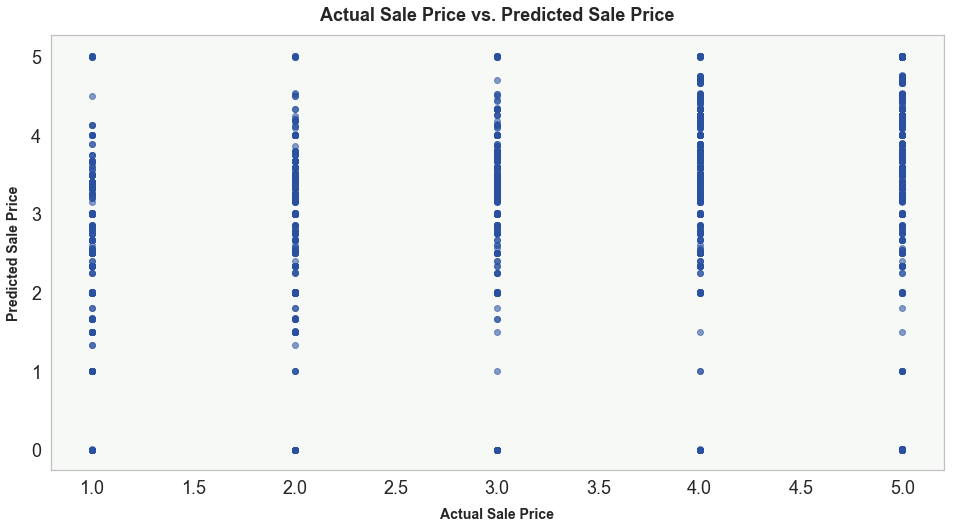

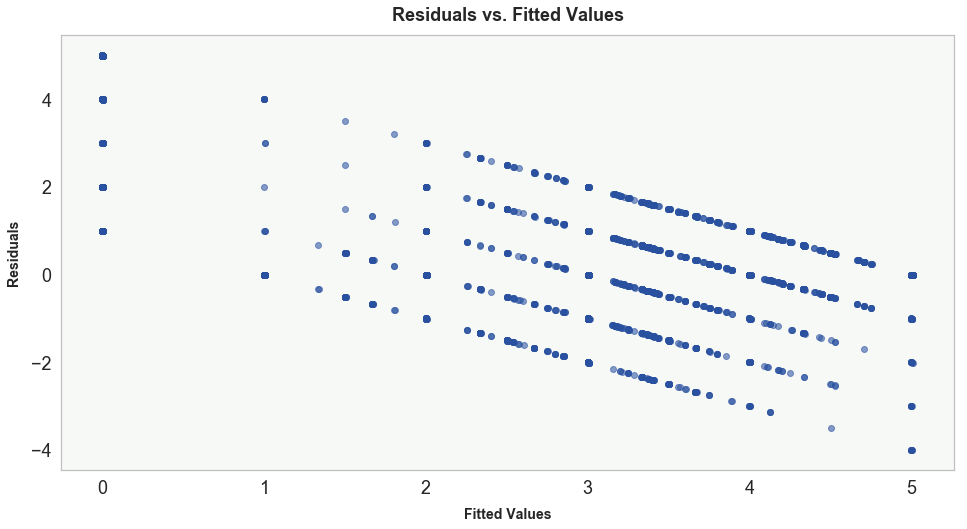

In [106]:
plot_fitted_vs_actual(data[0], data[1])
plot_fitted_vs_resid(data[0], data[1])

In [107]:
def evaluate_hold_out(hold_out_samples, result_matrix):
    results = []
    rating_data=[]
    fp = 0
    tp = 0
    tn = 0
    fn = 0
    for sample in hold_out_samples:
        if (sample[2] <= 2.5 and result_matrix[sample[0], sample[1]] <= 2.5) or (sample[2] > 2.5 and result_matrix[sample[0], sample[1]] > 2.5):
            results.append(1)
        rating_data.append((sample[2], result_matrix[sample[0], sample[1]]))
    
    for rating, prediction in rating_data:
        if rating < 2.5 and prediction > 2.5:
            fp += 1
        elif rating >2.5 and prediction > 2.5:
            tp += 1
        elif rating < 2.5 and prediction < 2.5:
            tn += 1
        else:
            fn += 1

    precision = tp/(tp+fp)
    recall = tp/(tp+fn)
    accuracy = sum(results)/len(hold_out_samples)
    return(rating_data, [accuracy, precision, recall], result_matrix)

def get_holdout_and_train_set(data, pct=.2):
    num_users, num_items = data.shape
    samples = [
    (i, j, data[i, j])
    for i in range(num_users)
    for j in range(num_items)
    if data[i, j] > 0
    ]
    hold_out_size = round(pct*len(samples))
    sample_indices = list(range(len(samples)))
    hold_out_indices = np.random.choice(sample_indices, hold_out_size, replace=False)

    hold_out_data =  [sample for i, sample in enumerate(samples) if i in hold_out_indices]
    train_data = [sample for i, sample in enumerate(samples) if i not in hold_out_indices]
    return hold_out_data, train_data


class MF():

    # Initializing the user-movie rating matrix, no. of latent features, alpha and beta.
    def __init__(self, R, data, K, alpha, beta, iterations):
        self.R = R
        self.num_users, self.num_items = R.shape
        self.K = K
        self.alpha = alpha
        self.beta = beta
        self.iterations = iterations
        self.error_log = []
        self.iteration_log = []
        self.hold_out_log = []
        self.data = data
        
    # Initializing user-feature and movie-feature matrix 
    def train(self):
        self.P = np.random.normal(scale=1./self.K, size=(self.num_users, self.K))
        self.Q = np.random.normal(scale=1./self.K, size=(self.num_items, self.K))

        # Initializing the bias terms
        self.b_u = np.zeros(self.num_users)
        self.b_i = np.zeros(self.num_items)
        self.b = np.mean(self.R[np.where(self.R != 0)])

        
        self.samples = self.data[1]
        self.eval_samples = self.data[0]
        
        training_process = []
        for i in range(self.iterations):
            np.random.shuffle(self.samples)
            self.sgd()
            mse = self.mse()
            hold_out_acc = self.evaluate()[1][0]
            training_process.append((i, mse))
            if (i+1) % 20 == 0:
                print("Iteration: %d ; error = %.4f ; hold-out accuracy: %4f" % (i+1, mse, hold_out_acc))
            self.error_log.append(mse)
            self.hold_out_log.append(hold_out_acc)
            self.iteration_log.append(i+1)
        return training_process

    # Computing total mean squared error
    def mse(self):
        xs, ys = self.R.nonzero()
        predicted = self.full_matrix()
        error = 0
        for x, y in zip(xs, ys):
            error += pow(self.R[x, y] - predicted[x, y], 2)
        return np.sqrt(error)

    # Stochastic gradient descent to get optimized P and Q matrix
    def sgd(self):
        for i, j, r in self.samples:
            prediction = self.get_rating(i, j)
            e = (r - prediction)

            self.b_u[i] += self.alpha * (e - self.beta * self.b_u[i])
            self.b_i[j] += self.alpha * (e - self.beta * self.b_i[j])

            self.P[i, :] += self.alpha * (e * self.Q[j, :] - self.beta * self.P[i,:])
            self.Q[j, :] += self.alpha * (e * self.P[i, :] - self.beta * self.Q[j,:])

    # Ratings for user i and moive j
    def get_rating(self, i, j):
        prediction = self.b + self.b_u[i] + self.b_i[j] + self.P[i, :].dot(self.Q[j, :].T)
        return prediction
    
    
    def evaluate(self, result_matrix=None):
        if result_matrix is None:
            result_matrix=self.full_matrix()
                               
        return(evaluate_hold_out(self.eval_samples, result_matrix))

    # Full user-movie rating matrix
    def full_matrix(self):
        return self.b + self.b_u[:,np.newaxis] + self.b_i[np.newaxis:,] + self.P.dot(self.Q.T)
    
    
    def accuracy_iteration_plot(self):
        plt.figure(figsize=(15,5))
        set_plot_style()
        plt.xlabel('Iteration')
        plt.ylabel('Accuracy')
        plt.title('Accuracy by Iteration')
        plt.plot(self.iteration_log, self.hold_out_log)
        plt.show()


In [108]:
data = (train_samples, hold_out_samples)
mf = MF(data_matrix, data, K=20, alpha=.02, beta=.02, iterations=80)
training_process = mf.train()
mf_result = mf.full_matrix()

Iteration: 20 ; error = 84.5910 ; hold-out accuracy: 0.722084
Iteration: 40 ; error = 83.6350 ; hold-out accuracy: 0.718653
Iteration: 60 ; error = 83.7341 ; hold-out accuracy: 0.718029
Iteration: 80 ; error = 83.8278 ; hold-out accuracy: 0.716781


In [109]:
#matrix factorization - [accuracy, precision, recall]
print(mf.evaluate()[1])

[0.7167810355583282, 0.7382640999662277, 0.9426476929711083]


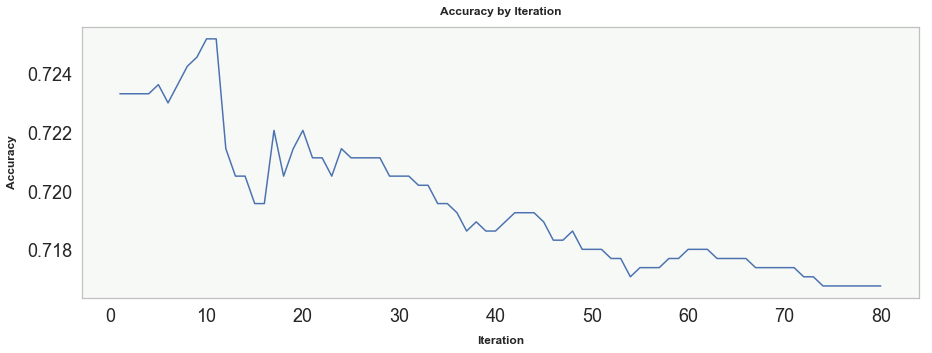

In [110]:
mf.accuracy_iteration_plot()

In [111]:
results = mf.evaluate()[0]
actual = [result[0] for result in results]
predicted = [result[1] for result in results]

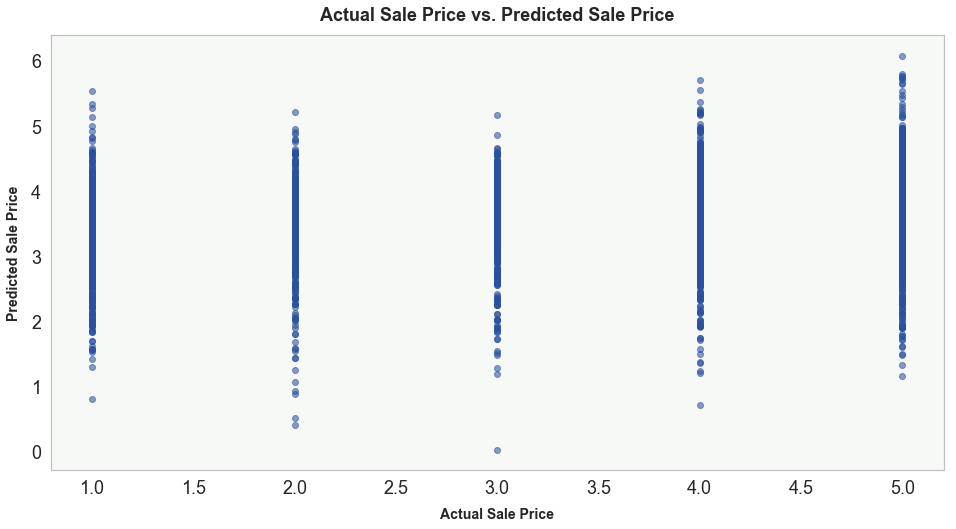

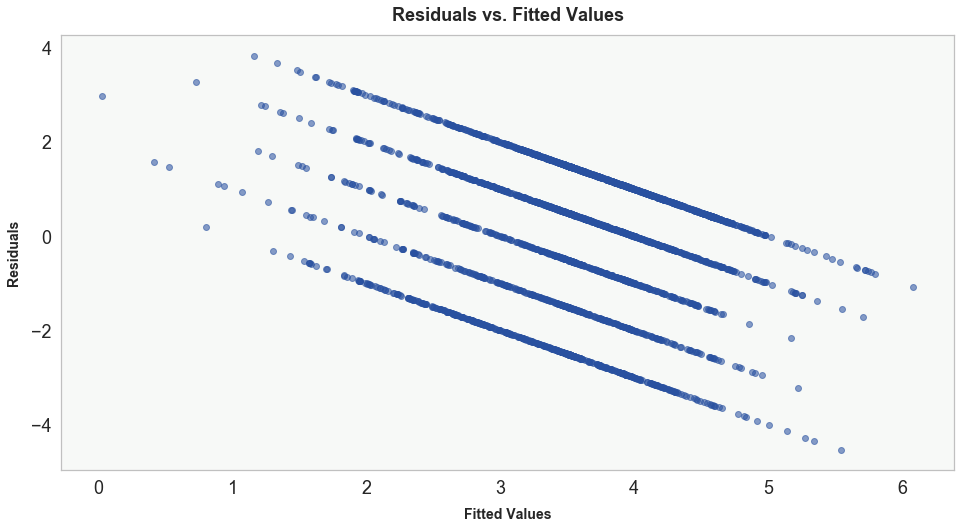

In [112]:
plot_fitted_vs_actual(actual, predicted)
plot_fitted_vs_resid(actual, predicted)

In [113]:
import sys, os
os.path.dirname(sys.executable)

'c:\\python35'

## Combining the results - Hybrid System

In [ ]:
user_prediction

In [ ]:
item_prediction

In [ ]:
mf_result

In [ ]:
combined_avg_prediction = (user_prediction + mf_result)/2

In [ ]:
combined_avg_prediction

In [ ]:
combined_result = evaluate_hold_out(hold_out_samples, combined_avg_prediction) 

In [ ]:
#hybrid similarity - [accuracy, precision, recall]
combined_result[1]

In [ ]:
calculate_error(data_matrix, combined_avg_prediction)

In [ ]:
calculate_error(data_matrix, combined_avg_prediction)

In [ ]:
data = get_predicted_vs_actual(data_matrix, combined_avg_prediction)

In [ ]:
plot_fitted_vs_actual(data[0], data[1])
plot_fitted_vs_resid(data[0], data[1])

## Sentiment analysis

In [ ]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score, roc_curve

In [ ]:
selected_reviews.head()
data = selected_reviews

In [ ]:
#Add a column for length of review
data['length'] = data['text'].apply(len)

In [ ]:
sns.set()
graph = sns.FacetGrid(data=data, col='stars')
_ = graph.map(plt.hist, 'length', bins=50, color='red')

In [ ]:
data.head()

In [ ]:
#Classification

data_classes = data[(data['stars']==1) | (data['stars']==3) | (data['stars']==5)]
data_classes.head(50)
print(data_classes.shape)

# Seperate the dataset into X and Y for prediction
x = data_classes['text']
y = data_classes['stars']
print(x.head())
print(y.head())

In [ ]:
#Removing punctuation and stopwords
import string
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
def process_text(text):
    nopunc = [char for char in text if char not in string.punctuation]
    nopunc = ''.join(nopunc)
    return [word for word in nopunc.split() if word.lower() not in stopwords.words('english')]

In [ ]:
 from sklearn.feature_extraction.text import CountVectorizer
# Vectorization
vocab = CountVectorizer(analyzer=process_text).fit(x)
print(len(vocab.vocabulary_))

In [ ]:
vocab.vocabulary_

In [ ]:
x = vocab.transform(x)
#Shape of the matrix:
print("Shape of the sparse matrix: ", x.shape)
#Non-zero occurences:
print("Non-Zero occurences: ",x.nnz)

# DENSITY OF THE MATRIX
density = (x.nnz/(x.shape[0]*x.shape[1]))*100
print("Density of the matrix = ",density)

In [ ]:
# Split the data into test and train sets
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.2,random_state=101)

### Multinomial Naive Bayes

In [ ]:
from sklearn.naive_bayes import MultinomialNB
mnb = MultinomialNB()
mnb.fit(x_train,y_train)
y_pred = mnb.predict(x_test)
print("Confusion Matrix for Multinomial Naive Bayes:")
print(confusion_matrix(y_test,y_pred))
print("Score:",round(accuracy_score(y_test,y_pred)*100,2))
print("Classification Report:",classification_report(y_test,y_pred))

### Random Forest Classifier

In [ ]:
from sklearn.ensemble import RandomForestClassifier
rmfr = RandomForestClassifier()
rmfr.fit(x_train,y_train)
predrmfr = rmfr.predict(x_test)
print("Confusion Matrix for Random Forest Classifier:")
print(confusion_matrix(y_test,y_pred))
print("Score:",round(accuracy_score(y_test,y_pred)*100,2))
print("Classification Report:",classification_report(y_test,y_pred))

### Decision Trees

In [ ]:
from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier()
dt.fit(x_train,y_train)
y_pred = dt.predict(x_test)
print("Confusion Matrix for Decision Tree:")
print(confusion_matrix(y_test,y_pred))
print("Score:",round(accuracy_score(y_test,y_pred)*100,2))
print("Classification Report:",classification_report(y_test,y_pred))

### Gradient Boosting Classifier

In [ ]:
# Gradient Boosting Classifier
from sklearn.ensemble import GradientBoostingClassifier
"""# parameter evaluation
gbe = GradientBoostingClassifier(random_state=0)
parameters = {
     'learning_rate': [0.05, 0.1, 0.5],
    'max_features': [0.5, 1],
    'max_depth': [3, 4, 5]}
gridsearch=GridSearchCV(gbe,parameters,cv=100,scoring='roc_auc')
gridsearch.fit(x,y)
print(gridsearch.best_params_)
print(gridsearch.best_score_)"""
#Boosting
gb_clf = GradientBoostingClassifier(learning_rate=0.1,max_depth=5,max_features=0.5,random_state=999999)
gb_clf.fit(x_train,y_train)
y_pred = gb_clf.predict(x_test)
print("Confusion Matrix for Gradient Boosting Classifier:")
print(confusion_matrix(y_test,y_pred))
print("Score:",round(accuracy_score(y_test,y_pred)*100,2))
print("Classification Report:",classification_report(y_test,y_pred))

### Multilayer Perception Classifier - Best Performer :)

In [ ]:
from sklearn.neural_network import MLPClassifier
mlp = MLPClassifier()
mlp.fit(x_train,y_train)
y_pred = mlp.predict(x_test)
print("Confusion Matrix for Multilayer Perceptron Classifier:")
print(confusion_matrix(y_test,y_pred))
print("Score:",round(accuracy_score(y_test,y_pred)*100,2))
print("Classification Report:")
print(classification_report(y_test,y_pred))

#### Making predictions with MPC - Positive Review

pr = data['text'][0]
print(pr)
print("\nActual Rating: ",data['stars'][0])
pr_t = vocab.transform([pr])
print("Predicted Rating: " + str(mlp.predict(pr_t)[0]))

#### Making predictions with MPC - Average Review

In [ ]:
ar = data['text'][6]
print(ar)
print("\nActual Rating: ",data['stars'][6])
ar_t = vocab.transform([ar])
print("Predicted Rating: " + str(mlp.predict(ar_t)[0]))

### Making predictions with MPC - Negative Review

In [ ]:
ar = data['text'][9]
print(ar)
print("\nActual Rating: ",data['stars'][9])
nr_t = vocab.transform([ar])
print("Predicted Rating: " + str(mlp.predict(nr_t)[0]))

## USE AN RNN - KERAS (high level abstraction on tensor flow)

In [ ]:
reviews = data['text']
stars = data['stars']
labels = ['1' if star >3 else '0' for star in stars]

In [ ]:
import string, re

def clean_up_text(text):
    punctuation = string.punctuation + '\n\n'
    punc_replace = ''.join([' ' for s in punctuation])
    text_clean = text.replace('-', ' ')
    text_alphas = re.sub(r'\W +', '', text_clean)
    trans_table = str.maketrans(punctuation, punc_replace)
    text_clean = ' '.join([word.translate(trans_table) for word in text_alphas.split(' ')]);
    text_clean = text_clean.split(' ')
    text_clean = [word.lower() for word in text_clean if len(word) > 0]
    
    return text_clean;

# Generate a cleaned reviews array from original review texts
reviews_cleaned = [clean_up_text(review) for review in reviews]
reviews = [' '.join(review) for review in reviews_cleaned]

In [ ]:
# Use a Keras Tokenizer and fit on the sentences
from keras.preprocessing.text import Tokenizer
tokenizer = Tokenizer();
tokenizer.fit_on_texts(reviews);
text_sequences = np.array(tokenizer.texts_to_sequences(reviews));
word_sequence_dict = tokenizer.word_index;
word_dict = dict((num, val) for (val, num) in word_sequence_dict.items());

# We get a map of encoding-to-word in sequence_dict

# Generate encoded reviews
reviews_encoded = [];
for i,review in enumerate(reviews_cleaned):
    reviews_encoded.append([word_sequence_dict[x] for x in review]);
    
# Plot a Histogram of length of reviews
lengths = [len(x) for x in reviews_encoded];
with plt.xkcd():
    plt.hist(lengths, bins=range(100))

In [ ]:
from keras.preprocessing.sequence import pad_sequences
# Truncate and Pad reviews at a Maximum cap of 60 words.
max_cap = 50;
X = pad_sequences(reviews_encoded, maxlen=max_cap, truncating='post')

# Obtain a One-hot Y array for each review label.
Y = np.array([[0,1] if '0' in label else [1,0] for label in labels])

# Get a randomized sequence of positions to shuffle reviews
random_posits = np.arange(len(X))
np.random.shuffle(random_posits);

# Shuffle X and Y
X = X[random_posits];
Y = Y[random_posits];

# Divide the reviews into Training, Dev, and Test data.
train_cap = int(0.85 * len(X));
dev_cap = int(0.93 * len(X));

X_train, Y_train = X[:train_cap], Y[:train_cap];
X_dev, Y_dev = X[train_cap:dev_cap], Y[train_cap:dev_cap];
X_test, Y_test = X[dev_cap:], Y[dev_cap:]

### Training the Model

In [ ]:
import tensorflow

In [ ]:
import sys
print(sys.version)

In [ ]:
import tensorflow
from keras.models import Sequential
from keras.layers import Dense, Activation, Embedding
from keras.layers import LSTM, Dropout
from keras.optimizers import Adam

In [ ]:
for row_idx, row in enumerate(X_dev):
    for idx, value in enumerate(row):
        if value > 35300:
            print(word_dict[value], row_idx, idx)

In [ ]:
model = Sequential();
model.add(Embedding(len(word_dict)+1, max_cap, input_length=max_cap));
model.add(LSTM(100, return_sequences=True));
model.add(LSTM(100));
model.add(Dense(100, activation='relu'));
model.add(Dense(2, activation='softmax'));
print(model.summary());

optimizer = Adam(lr=0.001, decay=0.0001);
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
# fit model
history = model.fit(X_train, Y_train, batch_size=80, epochs=10, validation_data=(X_dev, Y_dev))

In [ ]:

# Plot training & validation accuracy values
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [ ]:

model = Sequential();
model.add(Embedding(len(word_dict)+1, max_cap, input_length=max_cap));
model.add(LSTM(60, return_sequences=True, recurrent_dropout=0.5));
model.add(Dropout(0.5))
model.add(LSTM(60, recurrent_dropout=0.5));
model.add(Dense(60, activation='relu'));
model.add(Dense(2, activation='softmax'));
print(model.summary());

optimizer = Adam(lr=0.01, decay=0.001);
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
# fit model
history_w_reg = model.fit(X_train, Y_train, batch_size=64, epochs=10, validation_data=(X_dev, Y_dev))

In [ ]:

# Plot training & validation accuracy values
plt.plot(history_w_reg.history['acc'])
plt.plot(history_w_reg.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history_w_reg.history['loss'])
plt.plot(history_w_reg.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [ ]:
embeddings_index = dict();
with open('data/glove.6B.100d.txt', encoding='utf-8') as f:
    for line in f:
        values = line.split();
        word = values[0];
        coefs = np.asarray(values[1:], dtype='float32');
        embeddings_index[word] = coefs;
        
vocab_size = len(sequence_dict);
embeddings_matrix = np.zeros((vocab_size, 100));
for word, i in sequence_dict.items():
    embedding_vector = embeddings_index.get(word);
    if embedding_vector is not None:
        embeddings_matrix[i] = embedding_vector;

In [ ]:
from keras.preprocessing.sequence import pad_sequences
# Truncate and Pad reviews at a Maximum cap of 60 words.
max_cap = 100;
X = pad_sequences(reviews_encoded, maxlen=max_cap, truncating='post')

# Obtain a One-hot Y array for each review label.
Y = np.array([[0,1] if '0' in label else [1,0] for label in labels])

# Get a randomized sequence of positions to shuffle reviews
random_posits = np.arange(len(X))
np.random.shuffle(random_posits);

# Shuffle X and Y
X = X[random_posits];
Y = Y[random_posits];

# Divide the reviews into Training, Dev, and Test data.
train_cap = int(0.85 * len(X));
dev_cap = int(0.93 * len(X));

X_train, Y_train = X[:train_cap], Y[:train_cap];
X_dev, Y_dev = X[train_cap:dev_cap], Y[train_cap:dev_cap];
X_test, Y_test = X[dev_cap:], Y[dev_cap:]

In [ ]:
embeddings_matrix.shape

In [ ]:

model = Sequential();
model.add(Embedding(len(word_dict)+1, max_cap, input_length=max_cap, weights=[embeddings_matrix], trainable=False));
model.add(LSTM(60, return_sequences=True, recurrent_dropout=0.5));
model.add(Dropout(0.5))
model.add(LSTM(60, recurrent_dropout=0.5));
model.add(Dense(60, activation='relu'));
model.add(Dense(2, activation='softmax'));
print(model.summary());

optimizer = Adam(lr=0.01, decay=0.001);
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
# fit model
history = model.fit(X_train, Y_train, batch_size=64, epochs=10, validation_data=(X_dev, Y_dev))

In [ ]:
from numpy import array
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.embeddings import Embedding
# define documents
docs = ['Well done!',
		'Good work',
		'Great effort',
		'nice work',
		'Excellent!',
		'Weak',
		'Poor effort!',
		'not good',
		'poor work',
		'Could have done better.']
# define class labels
labels = array([1,1,1,1,1,0,0,0,0,0])
# integer encode the documents
vocab_size = 50
encoded_docs = [one_hot(d, vocab_size) for d in docs]
print(encoded_docs)
# pad documents to a max length of 4 words
max_length = 4
padded_docs = pad_sequences(encoded_docs, maxlen=max_length, padding='post')
print(padded_docs)
# define the model
model = Sequential()
model.add(Embedding(vocab_size, 8, input_length=max_length))
model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))
# compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
# summarize the model
print(model.summary())
# fit the model



model.fit(padded_docs, labels, epochs=50, verbose=0)
# evaluate the model
loss, accuracy = model.evaluate(padded_docs, labels, verbose=0)
print('Accuracy: %f' % (accuracy*100))